# CNC SMS Prediction Perceptron Future

Иммется временной ряд отправленных СМС оповещений за 4 месяца с периодичнотью в 10 минут.
Требуется выдать прогноз на n временных интервалов вперед и визуализировать результаты испольуя многослойный персептрон

In [78]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.advanced_activations import *
from keras import regularizers

pd.options.display.float_format = '{:.3f}'.format

Populating the interactive namespace from numpy and matplotlib


Загрузим входные данные, затем визуализируем их и выведем некоторые статистические показатели

count    24768.000
mean     68637.886
std      42793.965
min          1.000
25%      30642.750
50%      68145.500
75%      96240.000
max     886752.000
Name: Value, dtype: float64

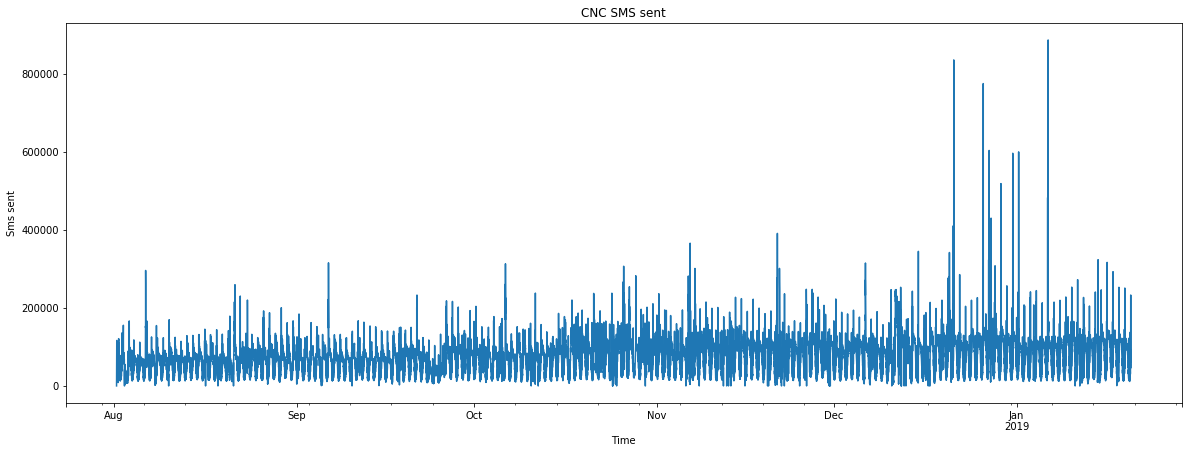

In [79]:
df = pd.read_csv('10min.csv', sep=';', index_col=['Time'], parse_dates=['Time'], dayfirst=True)
df = df.drop(df['Value'].tail(1).index)
n = int(df['Value'].size/2)
df = df[n:]
df['Value'] = df['Value'].apply(lambda text: ''.join(j for j in text if ord(j) < 128))
df['Value'] = df['Value'].apply(lambda val: float(val))
df['Value'] = df['Value'].apply(lambda val: 1 if val <= 0 else val)
df['Value'] = df['Value'].asfreq('10min', method='pad')
data = df['Value']
plt.figure(figsize(20,7))
data.plot()
plt.title("CNC SMS sent")
plt.ylabel('Sms sent')
    
data.describe()

#### Введем следующие параметры модели:  
**NUM_EPOCHS**  - сколько раз через модель прогонят всю обучающаю выборку  
**BATCH_SIZE** - по сколько примеров давать за раз  
**WINDOW** - размер временного окна  
**HORIZON**  - на сколько временных интревалов вперед будем брать прогноз при составлении врменного окна  

In [80]:
NUM_EPOCHS = 50
BATCH_SIZE = 32
WINDOW = 6*24*3
HORIZON = 6*12

Создадим множества X и Y  и разделим их на обучающую и тестовую выборки в соотношении 8/2

In [81]:
features = []  
labels = []

for i in range(WINDOW, data.size-HORIZON):  
    features.append(data[i-WINDOW:i])
    labels.append(data[i:i+HORIZON])

features, labels = np.array(features), np.array(labels) 

barrier = int(len(labels)*0.8)

Y_train = labels[:barrier]
X_train = features[:barrier]
Y_test = labels[barrier:]
X_test = features[barrier:]

В нашей архитектруе будет входной слой из 64 нейронов размерностью с окно прохода,  
Два скрытых слоя с дропаутом 0.5 между ними  
Данные бьудем подавать последовательно, без перемешки для сохранения свойств временной последовательности  
Так же введем колбэк *reduce_lr*, который будет уменьшать шаг градиентного спуска если ошибка вышла на плато
Функкцию активации возьмем *LeakyReLU*, которая равна:
$$f(x)={\begin{cases}x&{}x>0\\{\alpha}\cdot x&{}x\leq0\end{cases}}, \; где \; 0 < \alpha \ll 1$$

In [82]:
model = Sequential()
#*******************Input level**********************************
model.add(Dense(64, input_dim=WINDOW))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
#*******************Hidden level 1*********************************
model.add(Dense(128))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
#*******************Output level**********************************
model.add(Dense(HORIZON))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [89]:
history = model.fit(X_train, Y_train,
                    epochs=40,
                    batch_size=128*2,
                    validation_data=(X_test, Y_test),
                    callbacks=[]);

Train on 19411 samples, validate on 4853 samples
Epoch 1/40
19411/19411 [==============================] - 1s 26us/step - loss: 788125978.1361 - acc: 0.0247 - val_loss: 1505310798.7043 - val_acc: 0.0122
Epoch 2/40
19411/19411 [==============================] - 0s 24us/step - loss: 783457842.5281 - acc: 0.0248 - val_loss: 1504746162.7727 - val_acc: 0.0128
Epoch 3/40
19411/19411 [==============================] - 1s 27us/step - loss: 784299170.6195 - acc: 0.0254 - val_loss: 1509392072.2951 - val_acc: 0.0130
Epoch 4/40
19411/19411 [==============================] - 0s 24us/step - loss: 781267350.5225 - acc: 0.0253 - val_loss: 1509151850.8931 - val_acc: 0.0130
Epoch 5/40
19411/19411 [==============================] - 0s 24us/step - loss: 784482768.0074 - acc: 0.0229 - val_loss: 1508269235.7750 - val_acc: 0.0134
Epoch 6/40
19411/19411 [==============================] - 1s 26us/step - loss: 777733976.4876 - acc: 0.0249 - val_loss: 1506774364.0767 - val_acc: 0.0124
Epoch 7/40
19411/19411 [===

Выведем данные обучения модели: ошибку и точность

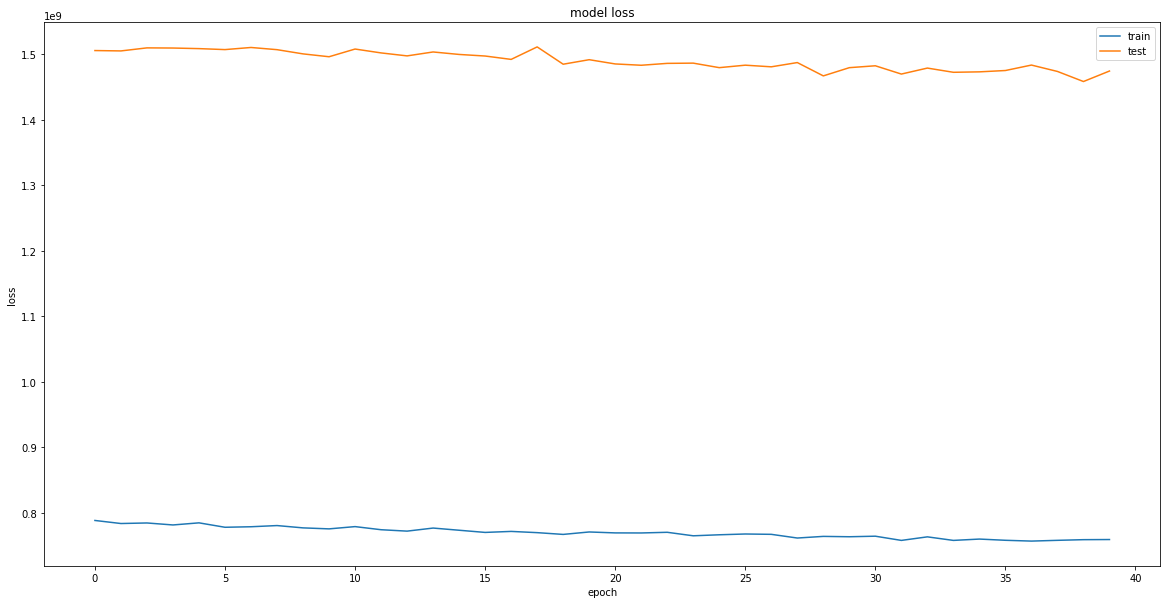

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Проверим коррекность нашей модели визуализировав результаты тестовой выборки

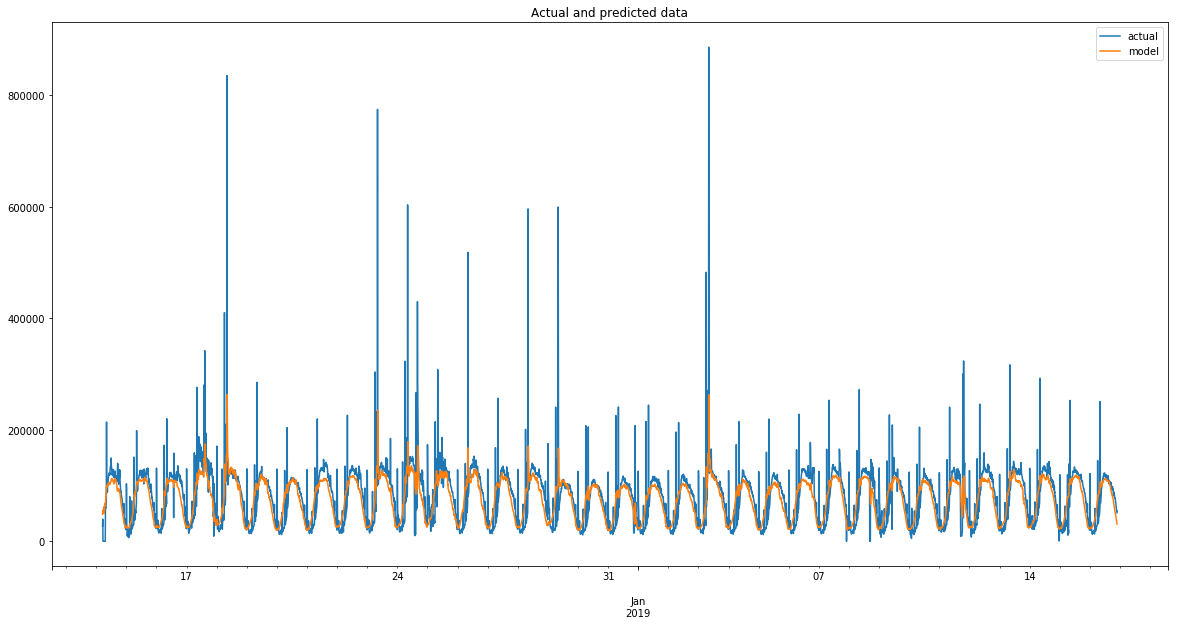

In [92]:
plt.figure(figsize(20,10))

pred = model.predict(X_test)

beg = data.index[barrier]
end = data.index[-WINDOW-HORIZON-1]


dates = pd.date_range(start=beg, end=end, freq='10min')

original = []
predict = []
for i in range(len(Y_test)):
    original.append(Y_test[i][0])
    predict.append(pred[i][0])
    
predicted = pd.Series(predict, index=dates)
actual = pd.Series(original, index=dates)

actual.plot(label='actual')
predicted.plot(label='model')
plt.legend(loc='best')
plt.title('Actual and predicted data')
plt.show()

А теперь визуализируем меньший интревал - 1 день

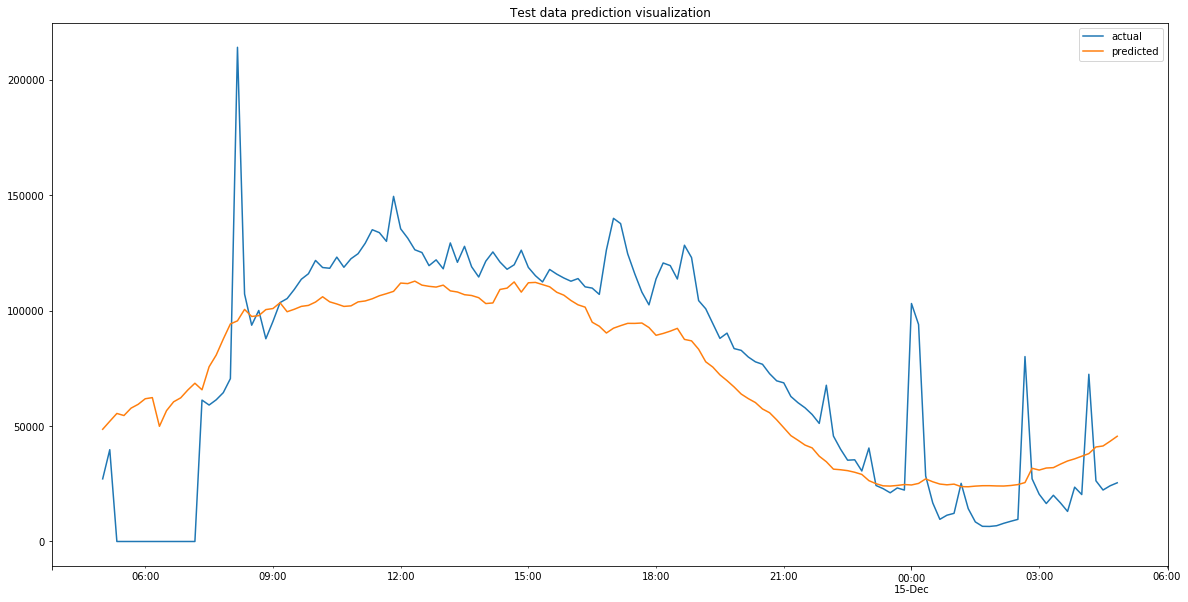

In [93]:
FROM = 0
TO = 6*24

actual[FROM:TO].plot(label='actual')
predicted[FROM:TO].plot(label='predicted')
plt.legend(loc='best')
plt.title('Test data prediction visualization')
plt.show()

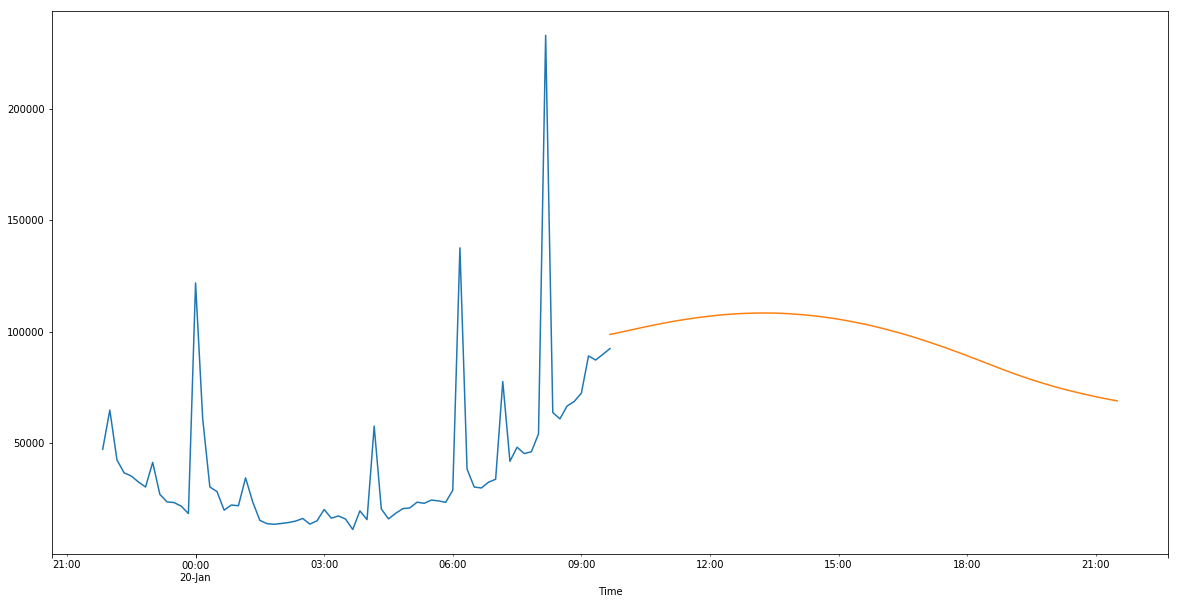

In [94]:
X_pred = []
for i in range(data.size-HORIZON, data.size):  
    X_pred.append(data[i-WINDOW:i])

X_pred = np.array(X_pred)

last_measurement = data.index[-1]
forecast_dates = pd.date_range(start=last_measurement, periods=HORIZON, freq='10min')

forecast_data = model.predict(X_pred)

forecast = pd.Series(forecast_data[-1],index=forecast_dates)

data[-HORIZON:].plot()
forecast.plot()